In [1]:
from huggingface_hub import hf_hub_download, login
import os, shutil, numpy as np

In [2]:
def load_folder(folder):
    X, Y = [], []
    for i in range(1, 2):
        X.append(np.load(f"{folder}/X{i}.npy"))
        Y.append(np.load(f"{folder}/Y{i}.npy"))
    return np.concatenate(X, axis=0), np.concatenate(Y, axis=0)

X_flatA, Y_flatA = load_folder("/kaggle/input/flatvel-a-preprocessed/FlatVel_A_preprocessed")
X_flatB, Y_flatB = load_folder("/kaggle/input/flatvel-b-preprocessed/FlatVel_B_preprocessed")
X_curveA, Y_curveA = load_folder("/kaggle/input/curvevel-a-preprocessed/CurveVel_A_preprocessed")
X_curveB, Y_curveB = load_folder("/kaggle/input/curvevel-b-preprocessed/CurveVel_B_preprocessed")

In [3]:
from sklearn.model_selection import train_test_split

def split_data(X, Y):
    return train_test_split(X, Y, test_size=0.3, random_state=42)

XA_tr, XA_val, YA_tr, YA_val = split_data(X_flatA, Y_flatA)
del X_flatA, Y_flatA
XB_tr, XB_val, YB_tr, YB_val = split_data(X_flatB, Y_flatB)
del X_flatB, Y_flatB,
XC_tr, XC_val, YC_tr, YC_val = split_data(X_curveA, Y_curveA)
del X_curveA, Y_curveA
XD_tr, XD_val, YD_tr, YD_val = split_data(X_curveB, Y_curveB)
del X_curveB, Y_curveB

In [4]:
import gc
gc.collect()

0

In [5]:
X_train = np.concatenate([XA_tr, XB_tr, XC_tr, XD_tr], axis=0)
Y_train = np.concatenate([YA_tr, YB_tr, YC_tr, YD_tr], axis=0)

In [6]:
del XA_tr, YA_tr, XB_tr, YB_tr, XC_tr, YC_tr, XD_tr, YD_tr
gc.collect()

0

In [7]:
val_sets = {
    "FlatA": (XA_val, YA_val),
    "FlatB": (XB_val, YB_val),
    "CurveA": (XC_val, YC_val),
    "CurveB": (XD_val, YD_val)
}

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import gc

In [9]:
class SmallResUNet(nn.Module):
    def __init__(self, in_ch=7, base=32):
        super().__init__()
        def res_block(in_c, out_c, dilation=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = res_block(in_ch, base, dilation=1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = res_block(base, base*2, dilation=2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = res_block(base*2, base*4, dilation=4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = res_block(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = res_block(base*2, base)

        self.outconv = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        b  = self.bottleneck(p2)

        d2 = self.up2(b)
        d2 = F.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.outconv(d1)
        out = F.interpolate(out, size=(70,70), mode='bilinear', align_corners=False)
        return out

In [10]:
def multiscale_loss(pred, gt, base_criterion):
    # pred,gt: tensors (B,1,H,W)
    loss = base_criterion(pred, gt)
    # half-scale
    p2 = F.interpolate(pred, scale_factor=0.5, mode='bilinear', align_corners=False)
    g2 = F.interpolate(gt, scale_factor=0.5, mode='bilinear', align_corners=False)
    loss = loss + 0.5 * base_criterion(p2, g2)
    # quarter-scale
    p4 = F.interpolate(pred, scale_factor=0.25, mode='bilinear', align_corners=False)
    g4 = F.interpolate(gt, scale_factor=0.25, mode='bilinear', align_corners=False)
    loss = loss + 0.25 * base_criterion(p4, g4)
    return loss


In [11]:
batch_size = 8
train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).float())
del X_train, Y_train
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
del train_ds

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallResUNet(in_ch=7, base=32).to(device)
base_criterion = nn.L1Loss()   # MAE base
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
for epoch in range(30):
    model.train()
    loss_sum = 0
    for xb,yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = base_criterion(out, yb)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    print(f"Epoch {epoch+1}: train L1={loss_sum/len(train_loader):.4f}")


Epoch 1: train L1=2889.7893
Epoch 2: train L1=2875.9258
Epoch 3: train L1=2852.6095
Epoch 4: train L1=2800.8810
Epoch 5: train L1=2729.9898
Epoch 6: train L1=2643.9913
Epoch 7: train L1=2550.2270
Epoch 8: train L1=2414.4613
Epoch 9: train L1=2264.8149
Epoch 10: train L1=2115.0201
Epoch 11: train L1=1929.0018
Epoch 12: train L1=1700.9872
Epoch 13: train L1=1633.0632
Epoch 14: train L1=1379.1945
Epoch 15: train L1=1234.6355
Epoch 16: train L1=1034.7693
Epoch 17: train L1=906.9875
Epoch 18: train L1=840.6815
Epoch 19: train L1=730.1811
Epoch 20: train L1=688.4882
Epoch 21: train L1=661.1011
Epoch 22: train L1=618.9506
Epoch 23: train L1=602.7096
Epoch 24: train L1=604.4728
Epoch 25: train L1=601.0336
Epoch 26: train L1=584.5835
Epoch 27: train L1=592.8785
Epoch 28: train L1=577.7730
Epoch 29: train L1=570.1346
Epoch 30: train L1=571.0182


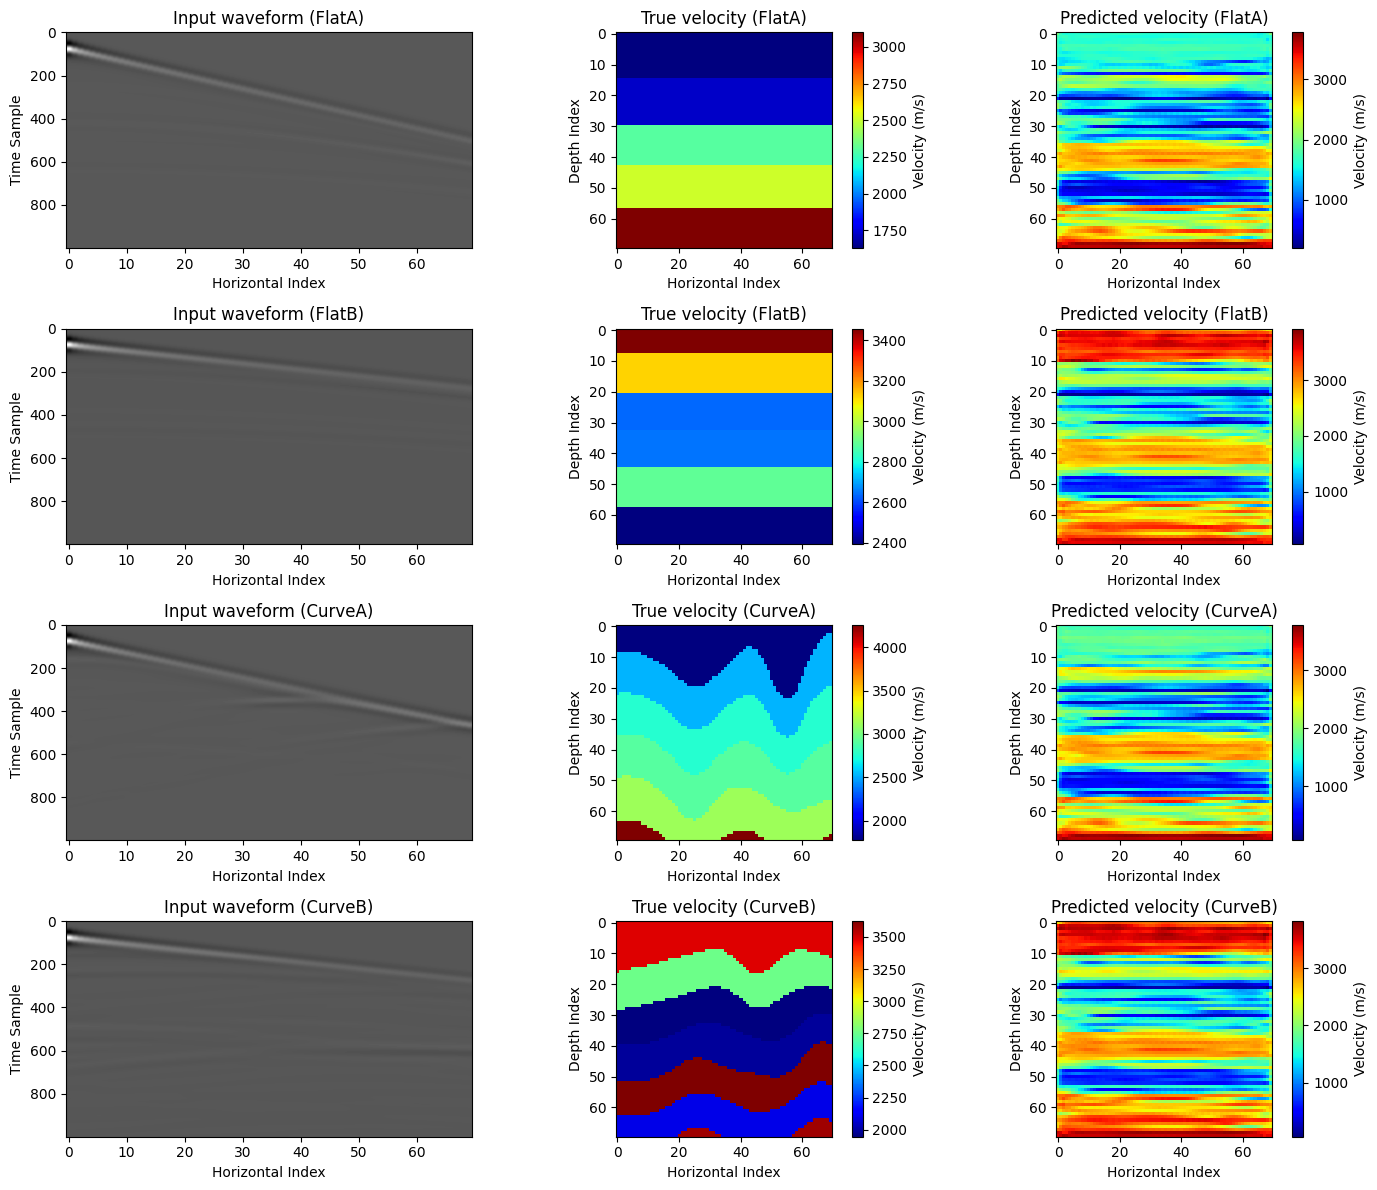

In [13]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    plt.figure(figsize=(14, 12))
    i = 1

    for name, (X_val, Y_val) in val_sets.items():
        # create small validation loader
        val_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_val).float(), torch.tensor(Y_val).float()
        )
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
        xb, yb = next(iter(val_loader))

        xb = xb.to(device)
        yb = yb.to(device)
        pred = model(xb).cpu()[0, 0]   # predicted velocity
        inp = xb[0, 0].cpu()           # input waveform
        true = yb[0, 0].cpu()          # true velocity

        # Input waveform
        plt.subplot(4, 3, i)
        plt.imshow(inp, aspect='auto', cmap='gray')
        plt.title(f"Input waveform ({name})")
        plt.xlabel("Horizontal Index")
        plt.ylabel("Time Sample")
        i += 1

        # True velocity
        plt.subplot(4, 3, i)
        plt.imshow(true, cmap='jet')
        plt.title(f"True velocity ({name})")
        plt.colorbar(label='Velocity (m/s)')
        plt.xlabel("Horizontal Index")
        plt.ylabel("Depth Index")
        i += 1

        # Predicted velocity
        plt.subplot(4, 3, i)
        plt.imshow(pred, cmap='jet')
        plt.title(f"Predicted velocity ({name})")
        plt.colorbar(label='Velocity (m/s)')
        plt.xlabel("Horizontal Index")
        plt.ylabel("Depth Index")
        i += 1

    plt.tight_layout()
    plt.show()
